In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.getcwd()

'/Users/prateekgarg'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils

In [129]:
import torchvision
import torchvision.transforms as transforms

N_TOKENS = 5
RESOLUTION = 16 # 16x16 images
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((RESOLUTION, RESOLUTION))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MAX_BATCH_SIZE = max(len(trainset), len(testset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=MAX_BATCH_SIZE, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=MAX_BATCH_SIZE, shuffle=False)

for i, data in enumerate(trainloader, 0):
    train_images, train_labels = data
    break

for i, data in enumerate(testloader, 0):
    test_images, test_labels = data
    break

data_min = train_images.min()
data_max = train_images.max()

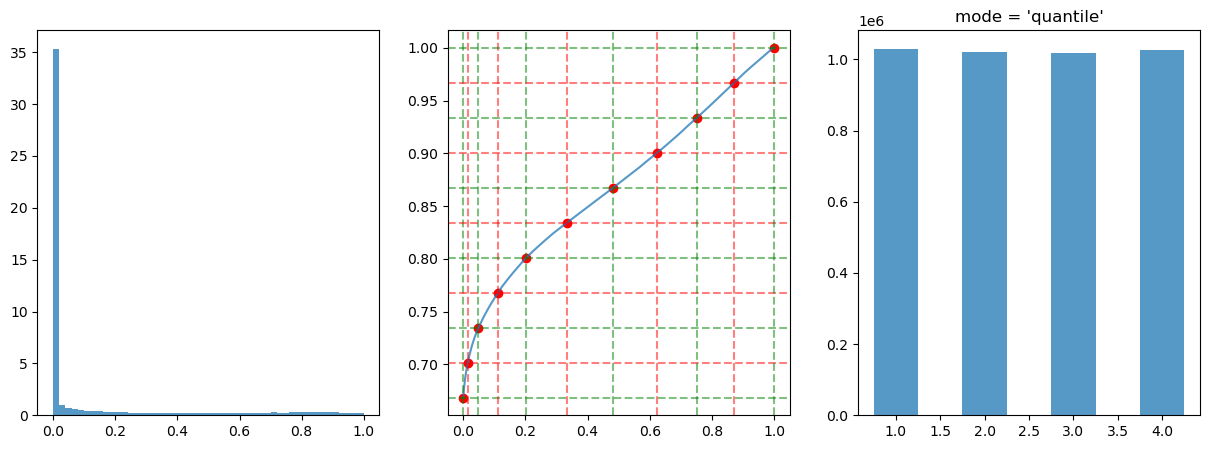

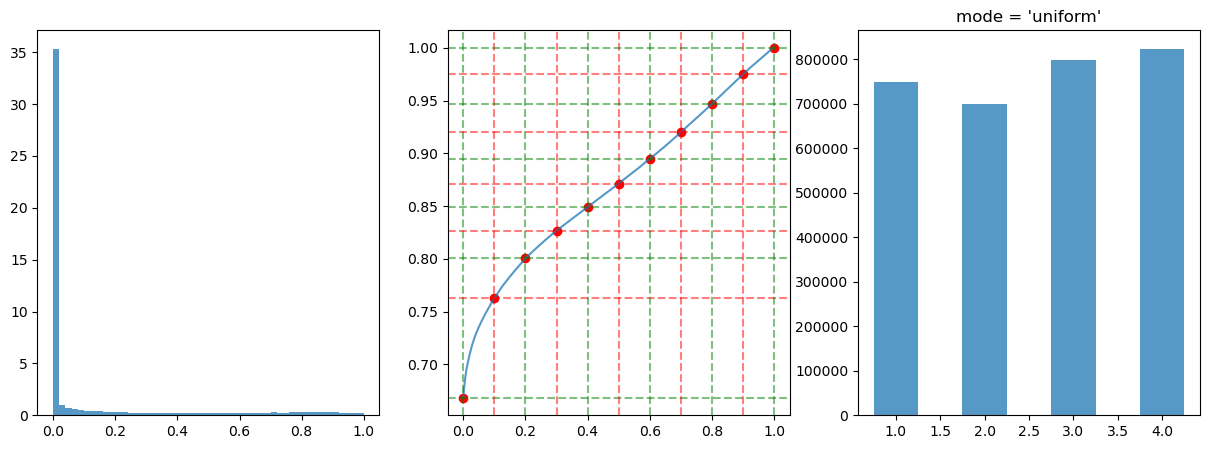

In [132]:
for mode in ['quantile', 'uniform']:
    pixel_values = train_images.flatten().numpy()
    hist, bins = np.histogram(pixel_values, bins=500)
    cdf = hist.cumsum()
    cdf = cdf / cdf[-1] 


    if mode == 'uniform':
        x_values = np.linspace(data_min, data_max, 2 * N_TOKENS + 1)
        y_values = np.interp(x_values, bins[:-1], cdf, right=True)
    elif mode == 'quantile':
        y_values = np.linspace(cdf.min(), cdf.max(), 2 * N_TOKENS + 1)
        x_values = np.interp(y_values, cdf, bins[:-1], right=True)
        x_values[-1] = data_max

    bin_boundaries = x_values[::2]
    bin_centers = x_values[1::2]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist(pixel_values, bins=50, alpha=0.75, density=True)
    ax[1].plot(bins[:-1], cdf, alpha=0.75)

    for i,(x, y) in enumerate(zip(x_values, y_values)):
        if i % 2 == 0:
            ax[1].axhline(y=y, color='green', linestyle='--', alpha=0.5)
            ax[1].axvline(x=x, color='green', linestyle='--', alpha=0.5)
        else:
            ax[1].axhline(y=y, color='red', linestyle='--', alpha=0.5)
            ax[1].axvline(x=x, color='red', linestyle='--', alpha=0.5)
    ax[1].scatter(x_values, y_values, color='red')


    tokens = np.digitize(train_images.numpy(), bin_boundaries) - 1
    tokens[tokens == N_TOKENS] = N_TOKENS - 1
    flattened_tokens = tokens.flatten()
    unique, counts = np.unique(flattened_tokens, return_counts=True)
    

    # ax[2].bar(unique, counts, width=0.5, align='center', alpha=0.75)
    ax[2].bar(unique[1:], counts[1:], width=0.5, align='center', alpha=0.75)
    plt.title(f'{mode = }')
    plt.show()
